# Advanced details

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/tgp-team/torch-geometric-pool/blob/main/docs/source/tutorials/advanced.ipynb)

In the following, we will analyze in more details the pooler operators, see how their components interact, and what differs from one operator to the others.

In [ ]:
import sys
import torch
if 'google.colab' in sys.modules:
    import os
    os.environ["TORCH"] = torch.__version__
    !pip install -qU pip "numpy>=2,<3"
    !pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
    !pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
    !pip install -q git+https://github.com/pyg-team/pytorch_geometric.git
    !pip install -q \
        "torch_geometric_pool[notebook] @ git+https://github.com/tgp-team/torch-geometric-pool.git"

In [3]:
import matplotlib.pyplot as plt
import networkx as nx
from torch_geometric.data import Batch, Data
from torch_geometric.datasets import TUDataset
from torch_geometric.loader import DataLoader
from torch_geometric.nn import NNConv
from torch_geometric.utils import to_networkx

from tgp.connect import DenseConnect, KronConnect, SparseConnect
from tgp.datasets import PyGSPDataset
from tgp.lift import BaseLift
from tgp.poolers import MinCutPooling, NDPPooling, TopkPooling
from tgp.reduce import BaseReduce, dense_global_reduce, global_reduce
from tgp.select import TopkSelect

torch.manual_seed(42)
torch.set_printoptions(threshold=3, edgeitems=3)

We will consider three pooling methods:
- [`TopkPooling`](https://torch-geometric-pool.readthedocs.io/en/latest/api/poolers.html#tgp.poolers.TopkPooling), a sparse pooling method with trainable parameters;
- [`NDPPooling`](https://torch-geometric-pool.readthedocs.io/en/latest/api/poolers.html#tgp.poolers.NDPPooling), a sparse pooling method without trainable parameters that precomputes the node assignments and the poole graph;
- [`MinCutPooling`](https://torch-geometric-pool.readthedocs.io/en/latest/api/poolers.html#tgp.poolers.MinCutPooling), a dense pooling method with trainable parameters and auxiliary losses.

Before looking at the pooling operators in detail, let's first load some data.

In [4]:
dataset = TUDataset(root="/tmp/MUTAG", name="MUTAG")
print(f"Dataset: {dataset}")
loader = DataLoader(dataset, batch_size=3, shuffle=True)
data_batch = next(iter(loader))
print(f"Data batch: {data_batch}")

Dataset: MUTAG(188)
Data batch: DataBatch(edge_index=[2, 138], x=[44, 7], edge_attr=[138, 4], y=[3], edge_weight=[138], batch=[44], ptr=[4])


/home/filippo/miniconda3/envs/tgp-test/lib/python3.9/site-packages/torch_geometric/data/dataset.py:240: UserWarning: The `pre_transform` argument differs from the one used in the pre-processed version of this dataset. If you want to make use of another pre-processing technique, pass `force_reload=True` explicitly to reload the dataset.
  warnings.warn(


The dataset contains edge attributes, i.e., vectors associated with each edge of the graph.
The pooling operators in <img src="../_static/img/tgp-logo.svg" width="20px" align="center" style="display: inline-block; height: 1.3em; width: unset; vertical-align: text-top;"/> tgp assume that the edge attributes are already embedded into the node features by a MP layers before pooling.
For the complete list of MP that support edge attributes refer to the [GNN cheatsheet](https://pytorch-geometric.readthedocs.io/en/2.6.1/cheatsheet/gnn_cheatsheet.html). 
A simple MP layer that does the job is [`NNConv`](https://pytorch-geometric.readthedocs.io/en/2.6.1/generated/torch_geometric.nn.conv.NNConv.html#torch_geometric.nn.conv.NNConv).

In [5]:
adj = data_batch.edge_index
batch = data_batch.batch
feat_size = 16

# Embed the node and edge features into new features
x = NNConv(
    in_channels=dataset.num_features,
    out_channels=feat_size,
    nn=torch.nn.Linear(dataset.num_edge_features, dataset.num_features * feat_size),
)(data_batch.x, adj, data_batch.edge_attr)

The edge features are now embedded into the node features `x`.

Let's now look at the pooling operators and their output.

In [6]:
# Instantiate the pooler
topk = TopkPooling(in_channels=feat_size)
print(topk)

# Compute the pooling output
topk_out = topk(x=x, adj=adj, batch=batch)
print(topk_out)

TopkPooling(
	select=TopkSelect(in_channels=16, ratio=0.5, act=Tanh(), s_inv_op=transpose)
	reduce=BaseReduce(reduce_op=sum)
	lift=BaseLift(matrix_op=precomputed, reduce_op=sum)
	connect=SparseConnect(reduce_op=sum, remove_self_loops=True)
	multiplier=1.0
)
PoolingOutput(so=[44, 23], x=[23, 16], edge_index=[2, 42], edge_weight=None, batch=[23], loss=None)


In [7]:
# Instantiate the pooler
ndp = NDPPooling()
print(ndp)

# Compute the pooling output
ndp_out = ndp(x=x, adj=adj, batch=batch)
print(ndp_out)

NDPPooling(
	select=NDPSelect(s_inv_op=transpose)
	reduce=BaseReduce(reduce_op=sum)
	lift=BaseLift(matrix_op=precomputed, reduce_op=sum)
	connect=KronConnect(sparse_threshold=0.01)
	cached=False
)
PoolingOutput(so=[44, 19], x=[19, 16], edge_index=[2, 60], edge_weight=[60], batch=[19], loss=None)


Since [`MinCutPooling`](https://torch-geometric-pool.readthedocs.io/en/latest/api/poolers.html#tgp.poolers.MinCutPooling) is a dense pooling layer, we need to preprocess the data.

In [8]:
# Instantiate the pooler
mincut = MinCutPooling(
    in_channels=feat_size, k=dataset._data.num_nodes // len(dataset) // 2
)
print(mincut)

# Preprocess data
x_dense, adj_dense, mask = mincut.preprocessing(x=x, edge_index=adj, batch=batch)

# Compute the pooling output
mincut_out = mincut(x=x_dense, adj=adj_dense, mask=mask)
print(mincut_out)

MinCutPooling(
	select=DenseSelect(in_channels=[16], k=8, act=None, dropout=0.0, s_inv_op=transpose)
	reduce=BaseReduce(reduce_op=sum)
	lift=BaseLift(matrix_op=precomputed, reduce_op=sum)
	connect=DenseConnect(remove_self_loops=False, degree_norm=False, adj_transpose=True)
	cut_loss_coeff=1.0
	ortho_loss_coeff=1.0
)
PoolingOutput(so=[20, 8], x=[3, 8, 16], edge_index=[3, 8, 8], edge_weight=None, batch=None, loss=['cut_loss', 'ortho_loss'])


A few things to keep in mind:

- Almost every method share the same $\texttt{RED}$ and $\texttt{LIFT}$ operators. 
- The $\texttt{SEL}$ operator is what sets most methods apart and, besides a few exceptions (e.g., [`NMFSelect`](https://torch-geometric-pool.readthedocs.io/en/latest/api/select.html#tgp.select.NMFSelect)) Dense poolers use the same $\texttt{SEL}$ operation. 
- Finally, $\texttt{CON}$ is usually implemented by [`SparseConnect`](https://torch-geometric-pool.readthedocs.io/en/latest/api/connect.html#tgp.connect.SparseConnect) or [`DenseConnect`](https://torch-geometric-pool.readthedocs.io/en/latest/api/connect.html#tgp.connect.DenseConnect), depending if the method is dense or sparse. However, there are a few exceptions such as [`NDPPooling`](https://torch-geometric-pool.readthedocs.io/en/latest/api/poolers.html#tgp.poolers.NDPPooling) that uses [`KronConnect`](https://torch-geometric-pool.readthedocs.io/en/latest/api/connect.html#tgp.connect.KronConnect).

## Select

The $\texttt{SEL}$ operator computes the assignment of the nodes to the supernodes of the pooled graph.
The output of the $\texttt{SEL}$ operator is stored inside the [`SelectOutput`](https://torch-geometric-pool.readthedocs.io/en/latest/api/select.html#tgp.select.SelectOutput).

The general signature of the $\texttt{SEL}$ operator is the following.

In [9]:
so_topk = topk.select(
    x=x, edge_index=adj, edge_weight=None, batch=batch, num_nodes=x.shape[0]
)
print(so_topk)

SelectOutput(num_nodes=44, num_clusters=23)


Not all arguments are used by a given pooling method. For example, [`TopkSelect`](https://torch-geometric-pool.readthedocs.io/en/latest/api/select.html#tgp.select.TopkSelect) requires only the node features `x` and `batch` to perform pooling.

In [10]:
so_topk = topk.select(
    x=x,
    batch=batch,
)
print(so_topk)

SelectOutput(num_nodes=44, num_clusters=23)


### SelectOutput

The [`SelectOutput`](https://torch-geometric-pool.readthedocs.io/en/latest/api/select.html#tgp.select.SelectOutput) has several fields.
The first and most important is `s`, which is the select matrix $\mathbf{S} \in \mathbb{R}^{N \times K}$.
In the case of a sparse pooler, `s` is a [`SparseTensor`](https://github.com/rusty1s/pytorch_sparse) representing $\mathbf{S}\in\mathbb{R}^{N\times K}$.

In [11]:
print(f"s type: {type(so_topk.s)}")
print(f"sparse_sizes: {so_topk.s.sparse_sizes()}")

s type: <class 'torch_sparse.tensor.SparseTensor'>
sparse_sizes: (44, 23)


The content of $\mathbf{S}$ can be accessed by the following properties of the [`SelectOutput`](https://torch-geometric-pool.readthedocs.io/en/latest/api/select.html#tgp.select.SelectOutput).

In [12]:
print(
    f"node index: {so_topk.node_index}\n"
    f"cluster_index: {so_topk.cluster_index}\n"
    f"weight: {so_topk.weight}\n"
)

node index: tensor([ 0,  1,  2,  ..., 36, 37, 38])
cluster_index: tensor([ 4,  3,  0,  ..., 17, 22, 18])
weight: tensor([0.6823, 0.6823, 0.7099,  ..., 0.7099, 0.6823, 0.7044],
       grad_fn=<IndexBackward0>)



```{note}
Note that we have gradients in  `weight`. 
In [`TopkPooling`](https://torch-geometric-pool.readthedocs.io/en/latest/api/poolers.html#tgp.poolers.TopkPooling) such weights allow for the gradients to pass through the non-differentiable top-$k$ operation.
```

Another important field of the [`SelectOutput`](https://torch-geometric-pool.readthedocs.io/en/latest/api/select.html#tgp.select.SelectOutput) is $\mathbf{S}_\text{inv}$, which is used by the $\texttt{LIFT}$ operation.

In [13]:
so_topk.s_inv

SparseTensor(row=tensor([ 0,  1,  2,  ..., 20, 21, 22]),
             col=tensor([ 2,  3,  5,  ..., 33, 34, 37]),
             val=tensor([0.7099, 0.7099, 0.7099,  ..., 0.6823, 0.6823, 0.6823],
                          grad_fn=<IndexBackward0>),
             size=(23, 44), nnz=23, density=2.27%)

By default, we `s_inv` is the transpose of `s`, i.e, $\mathbf{S}_\text{inv} = \mathbf{S}^\top$. 
However, we can also use the pseudo-inverse, $\mathbf{S}_\text{inv} = \mathbf{S}^+$.

In [14]:
so_topk_pinv = TopkSelect(in_channels=dataset.num_features, s_inv_op="inverse")(
    x=data_batch.x, batch=data_batch.batch
)
print(so_topk_pinv.s_inv)

SparseTensor(row=tensor([ 0,  1,  2,  ..., 20, 21, 22]),
             col=tensor([ 6,  9, 12,  ..., 33, 34, 35]),
             val=tensor([ 3.0269,  3.0269,  3.0269,  ..., 24.8659, 24.8659, 24.8659],
                          grad_fn=<IndexBackward0>),
             size=(23, 44), nnz=23, density=2.27%)


```{hint}
We can specify how to compute $\mathbf{S}_\text{inv}$ by setting either `s_inv_op="transpose"` or `s_inv_op="inverse"` when we instantiate the pooler.
```

There are a few other properites accessible from the [`SelectOutput`](https://torch-geometric-pool.readthedocs.io/en/latest/api/select.html#tgp.select.SelectOutput).
In particular, we check whether the pooling operator is expressive or not, according to the [expressivity conditions](https://arxiv.org/abs/2304.01575).

In [15]:
print(
    f"num_nodes: {so_topk.num_nodes}\n"
    f"num_clusters: {so_topk.num_clusters}\n"
    f"expressive: {so_topk.is_expressive}\n"
)

num_nodes: 44
num_clusters: 23
expressive: False



Sparse methods are generally not expressive, while dense methods are.

In [16]:
# Sparse select
so_ndp = ndp.select(
    edge_index=adj,
)
print(f"expressive: {so_ndp.is_expressive}\n")

expressive: False



In [17]:
# Dense select
so_mincut = mincut.select(
    x=x_dense,
)
print(f"expressive: {so_mincut.is_expressive}\n")

expressive: True



Generally, the select matrix $\mathbf{S}$ of a sparse method is a sparse matrix with one non-zero entry for each row, meaning that each node is assigned to *only one* supernode.

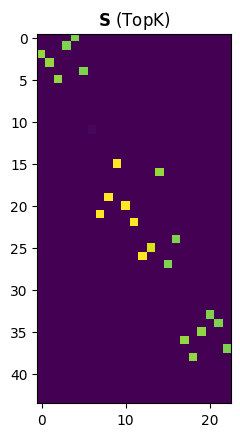

In [18]:
plt.imshow(so_topk.s.to_dense().detach().numpy(), cmap="viridis")
plt.title(r"$\mathbf{S}$ (TopK)");

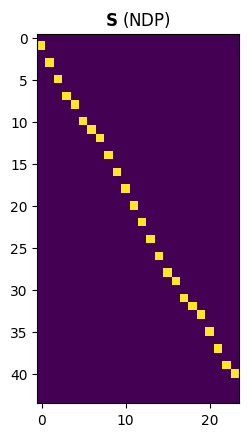

In [19]:
plt.imshow(so_ndp.s.to_dense().detach().numpy(), cmap="viridis")
plt.title(r"$\mathbf{S}$ (NDP)");

In dense methods such as [`MinCutPool`](https://torch-geometric-pool.readthedocs.io/en/latest/api/poolers.html#tgp.poolers.MinCutPooling), $\mathbf{S}\in\mathbb{R}^{B \times N \times K}$ is a dense soft cluster assignment matrix, usually computed directly from the node features $\mathbf{X}$ as:

$$\mathbf{S} = \mathrm{softmax}\big(\texttt{MLP}(\mathbf{X})\big).$$

In [20]:
print(f"so_mincut.s: {so_mincut.s.shape}")

so_mincut.s: torch.Size([3, 20, 8])


In the dense case, all the elements $\mathbf{S}$ are generally non-zero.

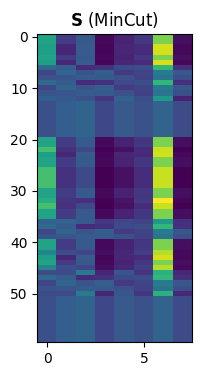

In [21]:
fig, ax = plt.subplots(figsize=(2, 4))
ax.imshow(
    so_mincut.s.detach().numpy().reshape(-1, so_mincut.num_clusters),
    cmap="viridis",
    aspect="auto",
)
plt.title(r"$\mathbf{S}$ (MinCut)");

## Reduce

The $\texttt{RED}$ operation determines how to compute the node features of the pooled graph $\mathbf{X}_\text{pool} \in \mathbb{R}^{K \times F}$ from the features $\mathbf{X} \in \mathbb{R}^{N \times F}$ of the original graph, given the [`SelectOutput`](https://torch-geometric-pool.readthedocs.io/en/latest/api/select.html#tgp.select.SelectOutput).

In [22]:
x_pool_topk, batch_pool_topk = topk.reduce(x, so_topk, batch=batch)
print(x_pool_topk.shape)

torch.Size([23, 16])


In practice, $\texttt{RED}$ computes the features of each supernode $i$ by aggregating the features of each node $i$ assigned to $j$. For example, when the aggregation is the sum, we have:

$$
\mathbf{X}_\text{pool}[i] = \sum_j \mathbf{S}_\text{inv}[j,i] \cdot \mathbf{X}[j].
$$

In general, we can use other types of aggregation, such as `"mean"`, `"max"`, etc...

In [23]:
mean_reduce = BaseReduce(reduce_op="mean")
x_pool_mean, _ = mean_reduce(x, so_topk, batch=batch)

```{hint}
We can change the type of reduce operation by setting `reduce_red_op="sum"`, `reduce_red_op="mean"`, etc... when we instantiate the pooler.
```

In the case of dense methods, the $\texttt{RED}$ operation does not require to provide the batch indexes, as the batch dimension is explicit in the first dimension of `x_dense`.

In [24]:
x_pool_mc, batch_pool_mc = mincut.reduce(x_dense, so_mincut)
print(x_pool_mc.shape)

torch.Size([3, 8, 16])


### Global reduce

Global reduce is the operation that aggregates all the nodes of a graph into a single output. This can be thought as a special case of $\texttt{RED}$, where all the nodes are aissgned to a single supernode and is often referred to as *global pooling* in the GNN literature.

```{attention}
The global pooling operation is called **global reduce** in <img src="../_static/img/tgp-logo.svg" width="40px" align="center" style="display: inline-block; height: 1.3em; width: unset; vertical-align: text-top;"/> tgp.
```


The aggreation operations used in global reduce are the same as the standard reduce, i.e., `"sum"`, `"mean"`, `"min"`, etc...

In [25]:
x_pool_glob = global_reduce(x_pool_topk, reduce_op="sum", batch=batch_pool_topk)
print(x_pool_glob.shape)

torch.Size([3, 16])


For dense methods we use the function [`dense_global_reduce`](https://torch-geometric-pool.readthedocs.io/en/latest/api/reduce.html#tgp.reduce.dense_global_reduce).
Also in this case, the batch is explicit in the first dimension and we do not need to pass the batch indices.

In [26]:
x_pool_glob_dense = dense_global_reduce(
    x_pool_mc, reduce_op="sum"
)  # we do not pass batch here
print(x_pool_glob_dense.shape)

torch.Size([3, 16])


Note that the output of [`global_reduce`](https://torch-geometric-pool.readthedocs.io/en/latest/api/reduce.html#tgp.reduce.global_reduce) and [`dense_global_reduce`](https://torch-geometric-pool.readthedocs.io/en/latest/api/reduce.html#tgp.reduce.dense_global_reduce) have the same shape.

## Connect

Given the original connectivity matrix $\mathbf{A}$ and the [`SelectOutput`](https://torch-geometric-pool.readthedocs.io/en/latest/api/select.html#tgp.select.SelectOutput), the $\texttt{CON}$ operation is responsible to generate the connectivity matrix of the pooled graph $\mathbf{A}_\text{pool}$. 

For sparse methods, [`SparseConnect`](https://torch-geometric-pool.readthedocs.io/en/latest/api/connect.html#tgp.connect.SparseConnect) returns a list of edges representing the edges of the pooled graphs in the batch.

In [27]:
ei_pool_topk, ew_pool_topk = topk.connect(
    edge_index=adj, edge_weight=data_batch.edge_weight, so=so_topk
)
print(f"A_pool (topk): {ei_pool_topk.shape}")

A_pool (topk): torch.Size([2, 42])


Sparse methods like [`TopkPooling`](https://torch-geometric-pool.readthedocs.io/en/latest/api/poolers.html#tgp.poolers.TopkPooling) that implements the $\texttt{CON}$ operation with [`SparseConnect`](https://torch-geometric-pool.readthedocs.io/en/latest/api/connect.html#tgp.connect.SparseConnect) allow to specify different types of aggregations for the edges. The default is `"sum"`, which leads to the following computation of the connectivity matrix:

$$
\mathbf{A}_\text{pool} = \mathbf{S}^\top \mathbf{A} \mathbf{S}_\text{inv}.
$$

Also in this case, other operations can be used to aggregate the edges by setting, e.g., `reduce_op="mean"` or `reduce_op="min"`. 
Additionally, the $\mathbf{A}_\text{pool}$ might contain self loops that can be removed by setting the correspondent flag.

In [28]:
sp_conn = SparseConnect(reduce_op="mean", remove_self_loops=True)
ei_pool_topk, ew_pool_topk = sp_conn(
    edge_index=adj, edge_weight=data_batch.edge_weight, so=so_topk
)
print(f"A_pool (topk): {ei_pool_topk.shape}")

A_pool (topk): torch.Size([2, 42])


```{hint}
We can specify how to aggregate the edges by, e.g., setting `connect_red_op="sum"` or `connect_red_op="mean"` when we instantiate the pooler.
```

Some particular methods like [`NDPPooling`](https://torch-geometric-pool.readthedocs.io/en/latest/api/poolers.html#tgp.poolers.NDPPooling) use a special  $\texttt{CON}$ operation, [`KronConnect`](https://torch-geometric-pool.readthedocs.io/en/latest/api/connect.html#tgp.connect.KronConnect), which behaves differently and does not offer the same options of [`SparseConnect`](https://torch-geometric-pool.readthedocs.io/en/latest/api/connect.html#tgp.connect.SparseConnect).

In [29]:
ei_pool_ndp, ew_pool_ndp = ndp.connect(
    edge_index=adj, edge_weight=data_batch.edge_weight, so=so_ndp
)
print(f"A_pool (ndp): {ei_pool_ndp.shape}")

A_pool (ndp): torch.Size([2, 74])


Or equivalently:

In [30]:
kron_conn = KronConnect()
ei_pool_ndp, ew_pool_ndp = kron_conn(
    edge_index=adj, edge_weight=data_batch.edge_weight, so=so_ndp
)
print(f"A_pool (ndp): {ei_pool_ndp.shape}")

A_pool (ndp): torch.Size([2, 74])


The dense methods use their own $\texttt{CON}$ method, [`DenseConnect`](https://torch-geometric-pool.readthedocs.io/en/latest/api/connect.html#tgp.connect.DenseConnect), which returns a dense tensor of shape $[B, K, K]$.
If `remove_self_loops = True` the diagonal of $\mathbf{A}_\text{pool}$ is set to zero, while `degree_norm = True` applies a symmetric degree-normalization and returns $\mathbf{\tilde A}_\text{pool} = \mathbf{D}^{-1/2}_\text{pool} \mathbf{A}_\text{pool} \mathbf{D}^{-1/2}_\text{pool}$.

In [31]:
dense_conn = DenseConnect(remove_self_loops=True, degree_norm=True)
adj_pool_mc, _ = dense_conn(adj_dense, so_mincut)
print(f"A_pool (mincut): {adj_pool_mc.shape}")

A_pool (mincut): torch.Size([3, 8, 8])


## Lift

The $\texttt{LIFT}$ operation maps the pooled node features $\mathbf{X}_\text{pool} \in \mathbb{R}^{K \times F}$ back to the original node space $\mathbf{X}_\text{lift} \in \mathbb{R}^{N \times F}$.
The $\texttt{LIFT}$ operation is implemented as:

$$
{X}_\text{lift} = \mathbf{S}_\text{inv} \mathbf{X}_\text{pool}.
$$

In [32]:
x_lift_topk = topk.lift(x_pool=x_pool_topk, so=so_topk)
print(f"x (original): {x.shape}")
print(f"x_pool (topk): {x_pool_topk.shape}")
print(f"x_lift (topk): {x_lift_topk.shape}")

x (original): torch.Size([44, 16])
x_pool (topk): torch.Size([23, 16])
x_lift (topk): torch.Size([44, 16])


Also in this case, the default aggregation is `"sum"`, but we can specify other aggregation types by setting, e.g., `reduce_op="mean"`.
We can also specify if we want to lift using $\mathbf{S}_\text{inv} = \mathbf{S}^\top$, $\mathbf{S}_\text{inv} = \mathbf{S}^+$, or just using the value currently stored in `SelectOutput.s_inv` by setting `matrix_op="transpose"`, `matrix_op="inverse"`, or `matrix_op="precomputed"`, respectively.

In [33]:
lifter = BaseLift(reduce_op="mean", matrix_op="inverse")
x_lift_topk = lifter(x_pool=x_pool_topk, so=so_topk)
print(f"x_lift (topk): {x_lift_topk.shape}")

x_lift (topk): torch.Size([44, 16])


```{hint}
We can specify the lift aggregation and the $\mathbf{S}_\text{inv}$ to be used by passing the desired values to the `lift_red_op` and `lift` variables of the pooler, respectively.
```

The same lifter can also be used for dense pooling operators.

In [34]:
x_lift_mc = lifter(x_pool=x_pool_mc, so=so_mincut)
print(f"x (dense): {x_dense.shape}")
print(f"x_pool (mincut): {x_pool_mc.shape}")
print(f"x_lift (mincut): {x_lift_mc.shape}")

x (dense): torch.Size([3, 20, 16])
x_pool (mincut): torch.Size([3, 8, 16])
x_lift (mincut): torch.Size([3, 20, 16])


## Combining and reusing existing operators

The existing implementations of the $\texttt{SEL}$, $\texttt{RED}$, $\texttt{CONN}$, and $\texttt{LIFT}$ operators can be combined in several ways and re-used when building new pooling methods.

For example, one could replace the connector of [`TopkPooling`](https://torch-geometric-pool.readthedocs.io/en/latest/api/poolers.html#tgp.poolers.TopkPooling) with [`KronConnect`](https://torch-geometric-pool.readthedocs.io/en/latest/api/connect.html#tgp.connect.KronConnect).

In [35]:
# Instantiate the pooler and replace the connector
topk_kron = TopkPooling(in_channels=feat_size, ratio=0.5)
topk_kron.connector = KronConnect()
print(topk_kron)

# Compute the pooling output
topk_kron_out = topk_kron(x=x, adj=adj, batch=batch)
print(topk_kron_out)

TopkPooling(
	select=TopkSelect(in_channels=16, ratio=0.5, act=Tanh(), s_inv_op=transpose)
	reduce=BaseReduce(reduce_op=sum)
	lift=BaseLift(matrix_op=precomputed, reduce_op=sum)
	connect=KronConnect(sparse_threshold=0.01)
	multiplier=1.0
)
PoolingOutput(so=[44, 23], x=[23, 16], edge_index=[2, 58], edge_weight=[58], batch=[23], loss=None)


/home/filippo/miniconda3/envs/tgp-test/lib/python3.9/site-packages/tgp/connect/kron_conn.py:69: UserWarning: Laplacian not provided. The SelectOutput is not computed with NDPSelect.
  warnings.warn(


In general, when implementing a new **sparse** pooling operator, it will likely re-use the existing [`BaseReduce`](https://torch-geometric-pool.readthedocs.io/en/latest/api/reduce.html#tgp.reduce.BaseReduce), [`SparseConnect`](https://torch-geometric-pool.readthedocs.io/en/latest/api/connect.html#tgp.connect.SparseConnect), and [`BaseLift`](https://torch-geometric-pool.readthedocs.io/en/latest/api/lift.html#tgp.lift.BaseLift) functions. Similarly, a **dense** pooling operator will likely use [`DenseSelect`](https://torch-geometric-pool.readthedocs.io/en/latest/api/select.html#tgp.select.DenseSelect), [`BaseReduce`](https://torch-geometric-pool.readthedocs.io/en/latest/api/reduce.html#tgp.reduce.BaseReduce), [`DenseConnect`](https://torch-geometric-pool.readthedocs.io/en/latest/api/connect.html#tgp.connect.DenseConnect), and [`BaseLift`](https://torch-geometric-pool.readthedocs.io/en/latest/api/lift.html#tgp.lift.BaseLift).

## Visualization

The modular and standardized API of the poolers in <img src="../_static/img/tgp-logo.svg" width="20px" align="center" style="display: inline-block; height: 1.3em; width: unset; vertical-align: text-top;"/> tgp allows for using the same functions to visualize the pooling results.
For testing and debugging, we can rely on the simple point clouds provided by the [PyGSP](https://pygsp.readthedocs.io/en/stable/) library for which <img src="../_static/img/tgp-logo.svg" width="20px" align="center" style="display: inline-block; height: 1.3em; width: unset; vertical-align: text-top;"/> tgp provide a wrapper for converting them into a proper torch dataset.
Below, we create a batch composed of a 2D-Grid, a Ring, and a Community graphs.

In [36]:
grid = PyGSPDataset(
    root="/tmp/PyGSP/",
    name="Grid2d",
    transform=None,
    pre_transform=None,
    pre_filter=None,
    force_reload=True,
    kwargs={"N1": 5, "N2": 5},
)[0]
print(f"2D-Grid: {grid}")

ring = PyGSPDataset(
    root="/tmp/PyGSP/",
    name="Ring",
    transform=None,
    pre_transform=None,
    pre_filter=None,
    force_reload=True,
    kwargs={"N": 30},
)[0]
ring.update({"x": ring.x + 2.0})
print(f"Ring: {ring}")

community = PyGSPDataset(
    root="/tmp/PyGSP/",
    name="Community",
    transform=None,
    pre_transform=None,
    pre_filter=None,
    force_reload=True,
    kwargs={"N": 18, "Nc": 3},
)[0]
community.update(
    {"x": torch.stack([community.x[:, 0] * 0.2 + 4.0, community.x[:, 1] * 0.2], dim=1)}
)
print(f"Community: {community}")

Processing...
Done!
Processing...
Done!
2025-06-08 10:14:07,854:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 1.4564753151219703


2D-Grid: Data(x=[25, 2], edge_index=[2, 80], y=[25], edge_weight=[80])
Ring: Data(x=[30, 2], edge_index=[2, 60], y=[30], edge_weight=[60])
Community: Data(x=[18, 2], edge_index=[2, 36], y=[18], edge_weight=[36])


Processing...
Done!


In [37]:
# Create a batch from the three datasets
pygsp_batch = Batch.from_data_list([grid, ring, community])
print(pygsp_batch)

DataBatch(x=[73, 2], edge_index=[2, 176], y=[73], edge_weight=[176], batch=[73], ptr=[4])


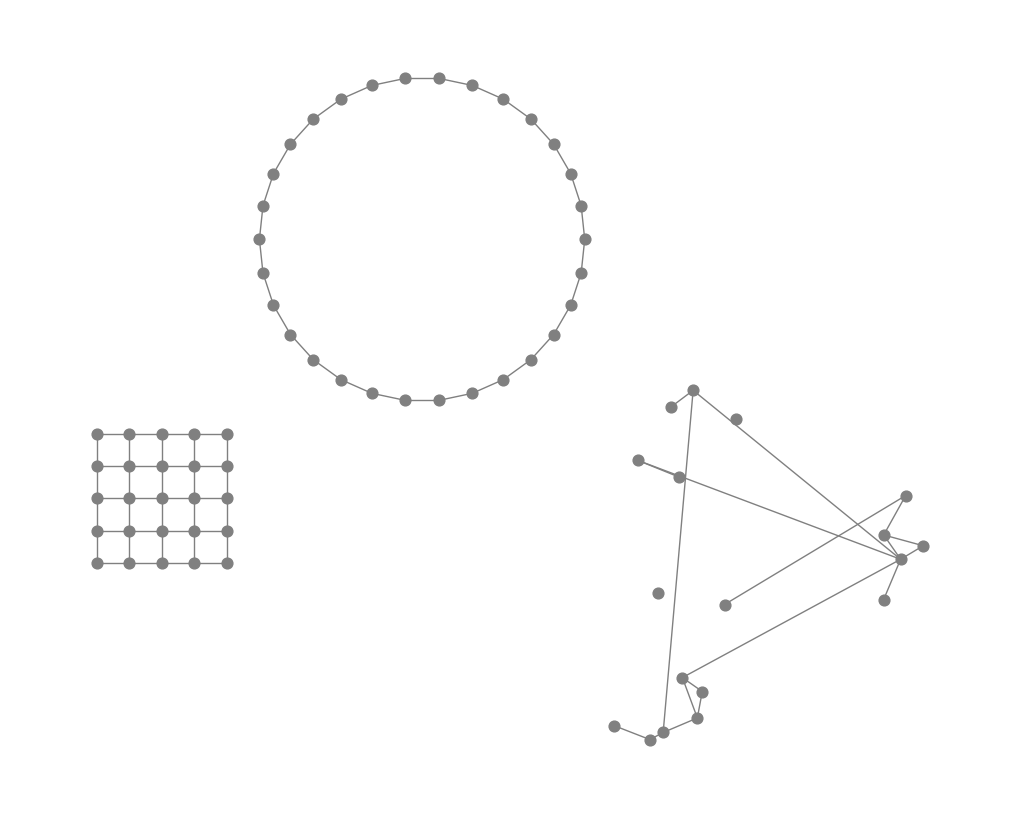

In [38]:
# Plot the batch
G = to_networkx(pygsp_batch, to_undirected=True)
plt.figure(figsize=(10, 8))
nx.draw(
    G, pos=pygsp_batch.x.numpy(), node_size=60, node_color="gray", edge_color="gray"
)

Let's first consider the [`NDPPooling`](https://torch-geometric-pool.readthedocs.io/en/latest/api/poolers.html#tgp.poolers.NDPPooling), which is a sparse method that is not trained and, as such, can provide a meaningful pooling output without performing any training.

In [39]:
# Instantiate the pooler and compute the output
ndp = NDPPooling()
ndp_out = ndp(x=pygsp_batch.x, adj=pygsp_batch.edge_index, batch=pygsp_batch.batch)

Below, we visualize the outcome of the $\texttt{SEL}$ operation. 
[`NDPPooling`](https://torch-geometric-pool.readthedocs.io/en/latest/api/poolers.html#tgp.poolers.NDPPooling) selects one-very-other nodes, meaning that we expect to see the selected nodes to be disconnected.

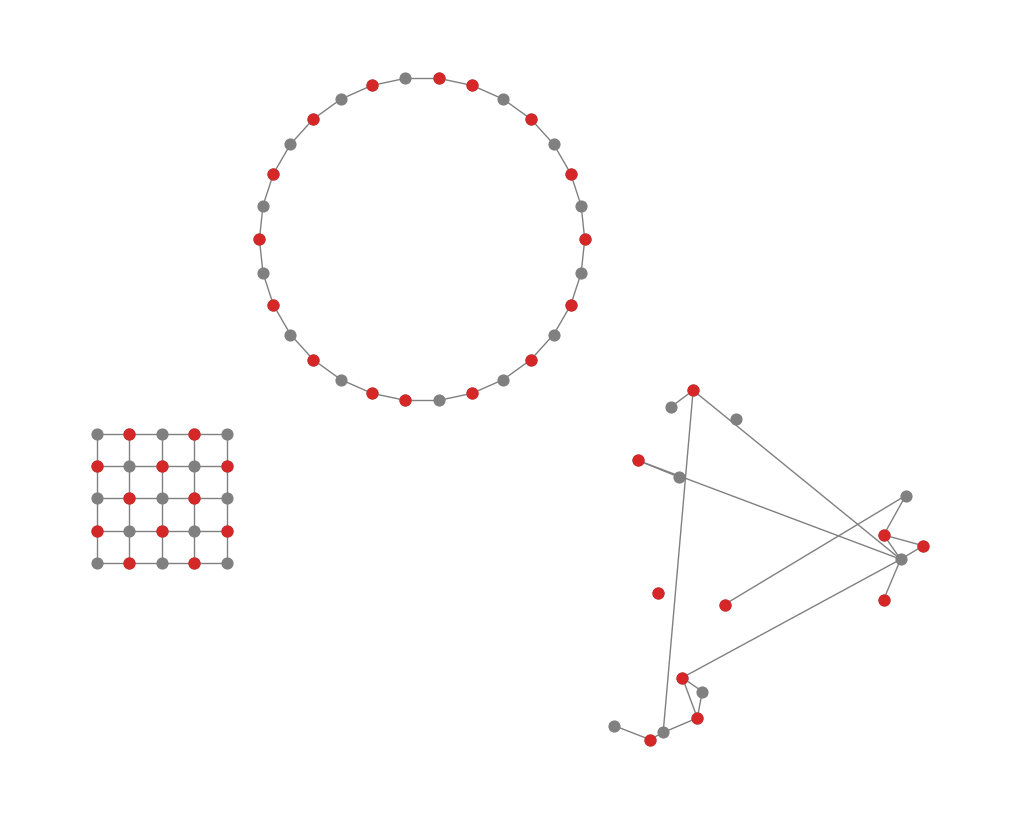

In [40]:
plt.figure(figsize=(10, 8))
nx.draw(
    G, pos=pygsp_batch.x.numpy(), node_size=60, node_color="gray", edge_color="gray"
)

# We plot in different colors the selected nodes
nx.draw_networkx_nodes(
    G,
    pos=pygsp_batch.x.numpy(),
    nodelist=ndp_out.so.node_index,  # selected nodes
    node_color="tab:red",
    node_size=60,
);

Finally, we can plot $\mathbf{X}_\text{pool}$ (we use different colors for each graph in the batch) and $\mathbf{A}_\text{pool}$ (orange edges).

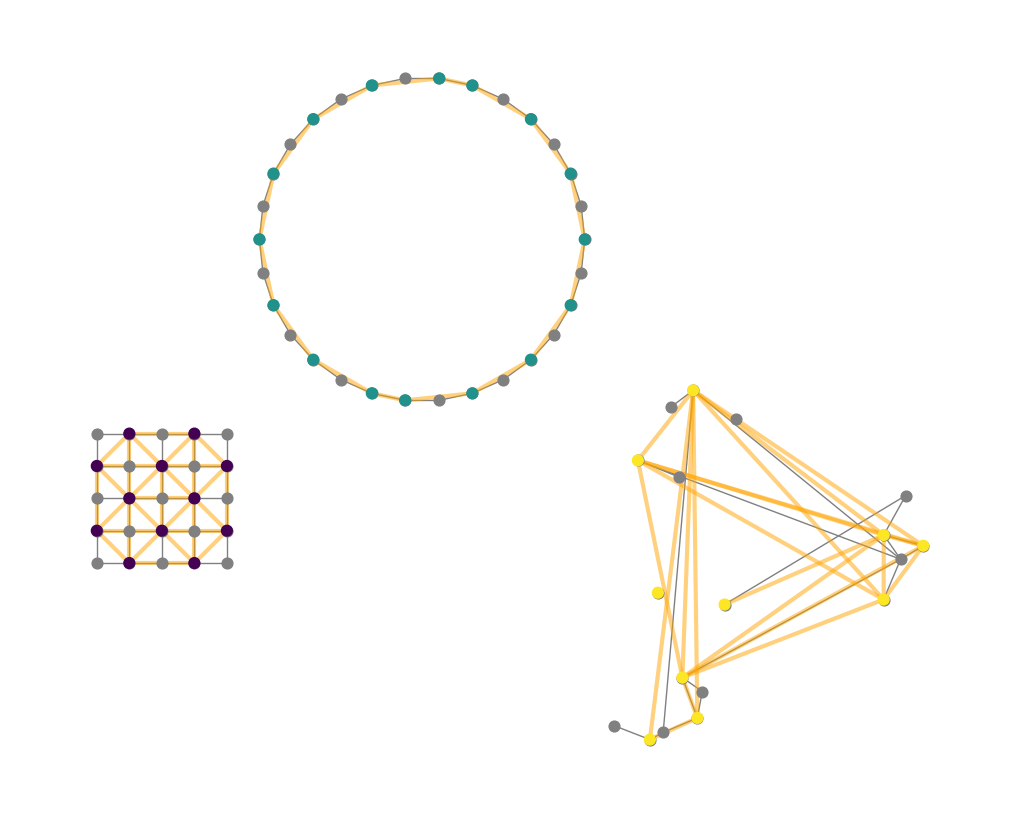

In [41]:
g_pooled = Data(
    x=ndp_out.x, edge_index=ndp_out.edge_index, edge_weight=ndp_out.edge_weight
)
G_pooled = to_networkx(g_pooled, to_undirected=True)

plt.figure(figsize=(10, 8))
nx.draw(
    G, pos=pygsp_batch.x.numpy(), node_size=60, node_color="gray", edge_color="gray"
)
nx.draw_networkx_nodes(
    G_pooled, pos=ndp_out.x.numpy(), node_size=60, node_color=ndp_out.batch
)
nx.draw_networkx_edges(
    G_pooled, pos=ndp_out.x.numpy(), edge_color="orange", width=3, alpha=0.5
);

We can use the same procedure to plot the selected nodes of other poolers. 
For [`TopkPooling`](https://torch-geometric-pool.readthedocs.io/en/latest/api/poolers.html#tgp.poolers.TopkPooling) we get the following.

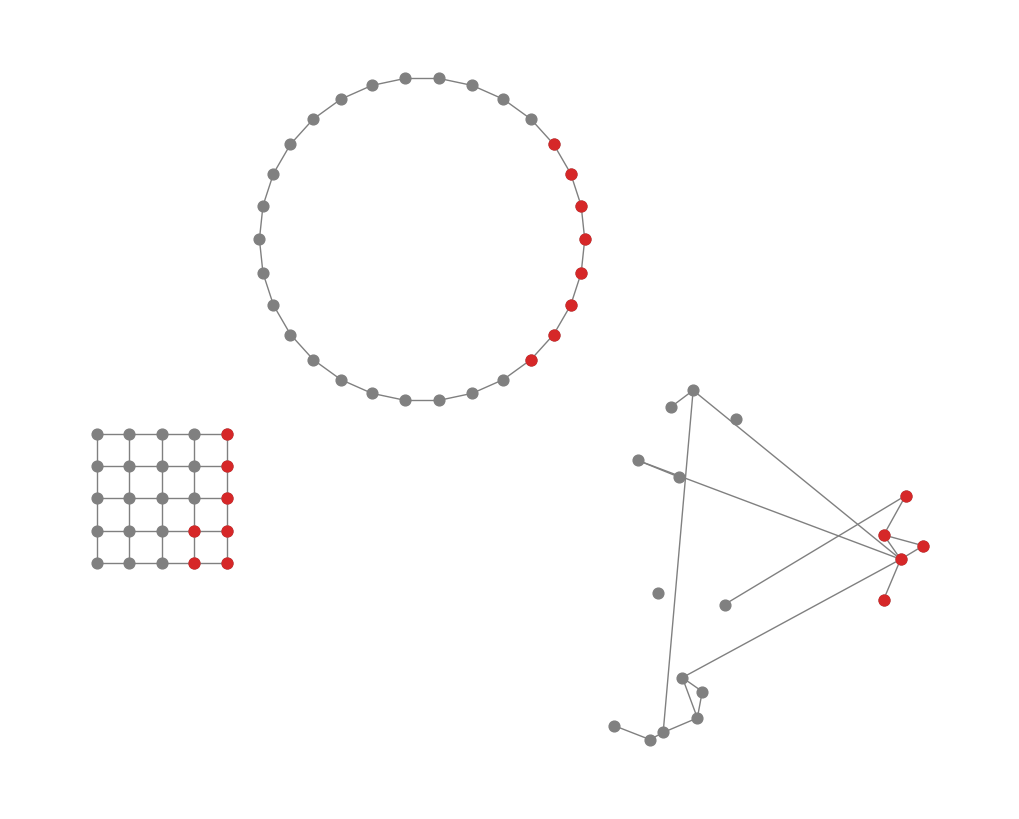

In [42]:
# Instantiate the pooler and compute the output
topk = TopkPooling(in_channels=2, ratio=0.25)
topk_out = topk(x=pygsp_batch.x, adj=pygsp_batch.edge_index, batch=pygsp_batch.batch)

plt.figure(figsize=(10, 8))
nx.draw(
    G, pos=pygsp_batch.x.numpy(), node_size=60, node_color="gray", edge_color="gray"
)

# We plot in different colors the selected nodes
nx.draw_networkx_nodes(
    G,
    pos=pygsp_batch.x.numpy(),
    nodelist=topk_out.so.node_index,  # selected nodes
    node_color="tab:red",
    node_size=60,
);

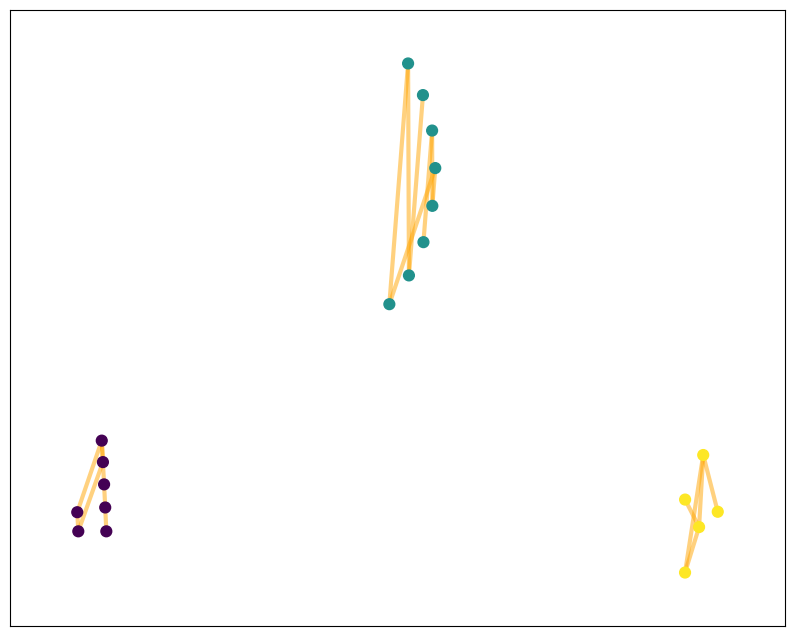

In [43]:
# Plot the pooled graph
g_pooled = Data(
    x=topk_out.x, edge_index=topk_out.edge_index, edge_weight=topk_out.edge_weight
)
G_pooled = to_networkx(g_pooled, to_undirected=True)

plt.figure(figsize=(10, 8))
nx.draw_networkx_nodes(
    G_pooled, pos=topk_out.x.detach().numpy(), node_size=60, node_color=topk_out.batch
)
nx.draw_networkx_edges(
    G_pooled, pos=topk_out.x.detach().numpy(), edge_color="orange", width=3, alpha=0.5
);

Note that the result in this case does not make much sense because [`TopkPooling`](https://torch-geometric-pool.readthedocs.io/en/latest/api/poolers.html#tgp.poolers.TopkPooling) must be trained to produce meaningful results.